# Example showing how to observe a full scene
# 1: using a one dimensional direct image and segmentation map
# 2: using multi-dimensional direct images and segmentation maps to account for overlapping sources in the direct image (disperse combintions of foreground/background objects).

### ETC_grism_dev version 0.5.0

# 0 - imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ETC_grism_dev
from ETC_grism_dev import background
from ETC_grism_dev import spectrum
from ETC_grism_dev import disperser
from ETC_grism_dev import utils

# 1 - Build/import the source direct image and associated segmentation map.

# Create the direct image scene

In [43]:
#Create sources in scene
#Use a sersic profiles
from astropy.modeling.models import Sersic2D

#CASTOR telescope pixel scale in arcsec
pix_scale = 0.1 

#fov in pixels (not the real castor fov)
fov_size = 100

#sources
x_positions = [10, 30, 60]
y_positions = [10, 30, 60]
sources_eff_radius_arcsec = np.array([3/7.5, 1.5/7.5, 4/7.5]) #arcsec
sources_eff_radius_pixels = sources_eff_radius_arcsec/pix_scale
sersic_indexes = [1, 1.5, 3]
ellipticities = [0.35, 0.5, 0.2]
seg_thresholds = [1e-2, 1e-2, 1e-3]

#scene grid
x,y = np.meshgrid(np.arange(fov_size), np.arange(fov_size))

#sersic models
sersic_models = [Sersic2D(amplitude = 1, r_eff = r_eff, n=n, x_0=x_pos, y_0=y_pos,
                    ellip=ellip, theta=-1) 
                    for r_eff, n, x_pos, y_pos, ellip 
                    in zip(sources_eff_radius_pixels, sersic_indexes, x_positions, y_positions, ellipticities)]
#images and seg maps
sources_img = [sersic_model(x, y) for sersic_model in sersic_models]
sources_seg = [(src_img/np.max(src_img) > segtresh) * k for src_img, segtresh, k in zip(sources_img, seg_thresholds, range(1,4))]

#add on grid/scene
scene_direct = np.nansum(sources_img, axis=0)
scene_seg = np.nansum(sources_seg, axis=0)


/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_50088/654451621.py:7: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([-1, 0, 1], update_ticks=True)


Text(0, 0.5, 'y')

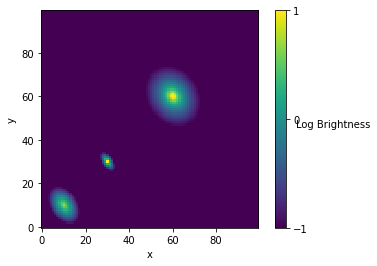

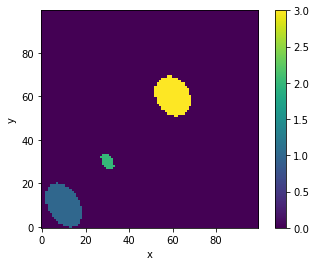

In [44]:
#direct image scene
plt.imshow(np.log10(scene_direct), origin='lower', interpolation='none', vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)

#segmentation map
plt.figure()
plt.imshow(scene_seg, origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')


# Generate the spectrum of each source

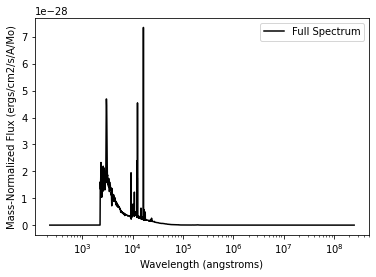

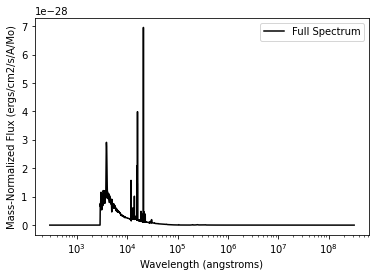

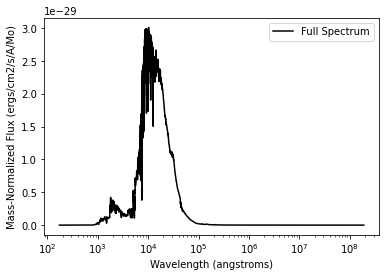

In [45]:
#Sources properties
sources_redshift = [1.5, 2.2, 0.9] #If a redshift other than 0 is provided, then spectrum is automatically redshifted.
fsps_params_dicts = [{"tau": 1, "logzsol": 0, "dust2": 0.2, "add_neb_emission": True},
                     {"tau": 2, "logzsol": 0, "dust2": 0.4, "add_neb_emission": True},
                     {"tau": 0.4, "logzsol": 0, "dust2": 0.1, "add_neb_emission": False}
                    ]
fsps_ages = [2, 1, 4] #Gyrs

#generate the (observed-frame) model spectra
spectra = []
for params, ages, z in zip(fsps_params_dicts, fsps_ages, sources_redshift):
    #generate spectrum
    spectrum.spectrum_from_fsps(spectrum, fsps_params_dict=params, fsps_age=ages, redshift=z, check=True)
    #save spectrum object
    spectra.append(spectrum.spectrum)


# Normalize the spectra

TARGET_FLAM, NON_NORM_FLAM, SCALING:  1.4694654524859772e-17 1.747031632948227e-28 84112126235.86906
NORM_FLAM, NORM_FNU, NORM_MAG:  1.469465452485977e-17 5.754399373371589 21.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  1.4694654524859772e-17 5.75439937337159 22


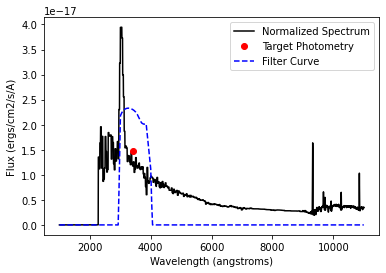

TARGET_FLAM, NON_NORM_FLAM, SCALING:  3.69113033167163e-18 1.2442820990542024e-28 29664738683.272175
NORM_FLAM, NORM_FNU, NORM_MAG:  3.691130331671629e-18 1.4454397707459397 23.499999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  3.69113033167163e-18 1.4454397707459399 23.5


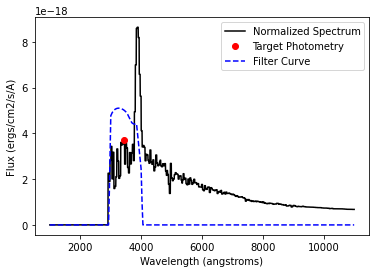

TARGET_FLAM, NON_NORM_FLAM, SCALING:  1.4694654524859772e-17 1.5739230592341905e-30 9336323296520.998
NORM_FLAM, NORM_FNU, NORM_MAG:  1.4694654524859772e-17 5.754399373371591 21.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  1.4694654524859772e-17 5.75439937337159 22


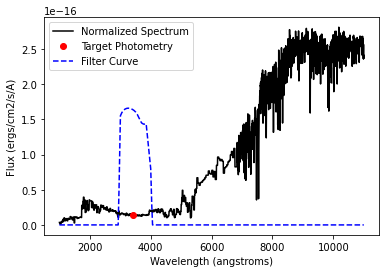

In [46]:
sources_mag = [22, 23.5, 22]
filter_channel = "u"

spectra_norm = []
for src_spec, mag in zip(spectra, sources_mag):
    #grab spectrum
    spectrum.spectrum = src_spec
    #normalize spectrum
    spectrum.normalize_spectrum(spectrum, magnitude=mag, filter_channel=filter_channel, check=True)
    #save
    spectra_norm.append(spectrum.spectrum)
    

# Disperse and observe the grism scene

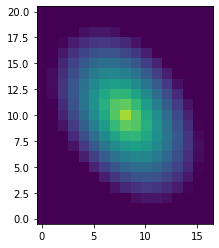

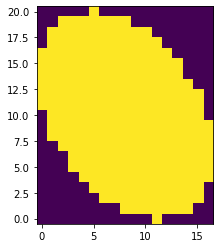

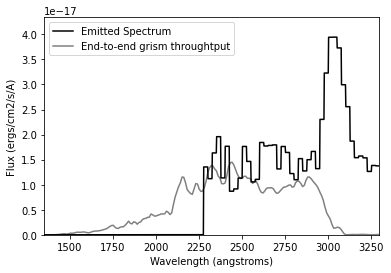

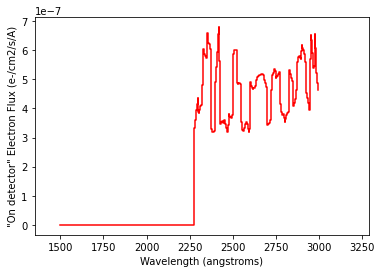

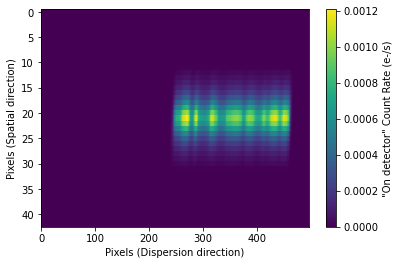

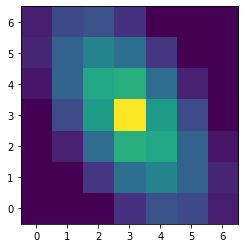

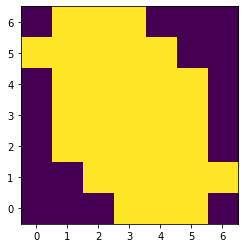

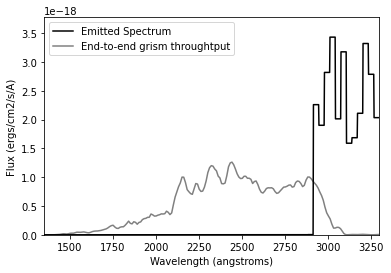

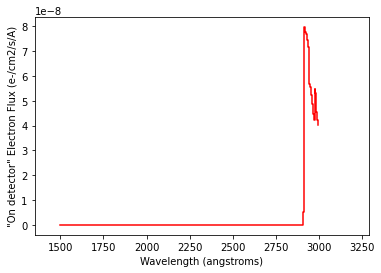

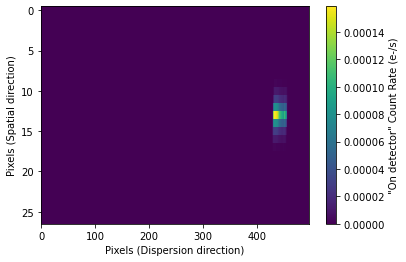

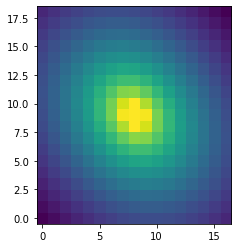

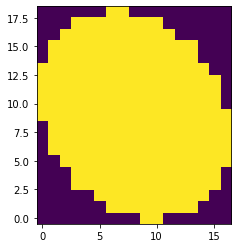

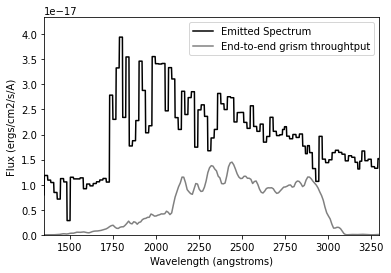

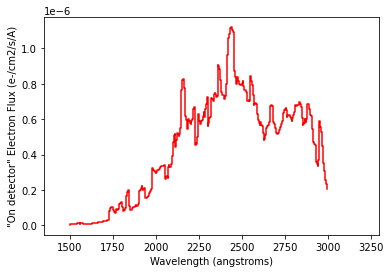

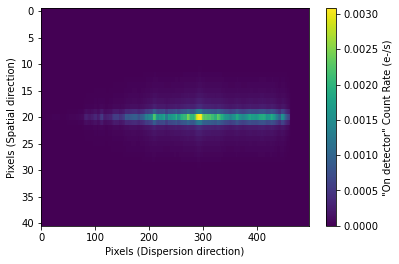

In [47]:
#scene properties
spectra = spectra_norm
scene_direct = scene_direct
scene_seg = scene_seg

#Disperse/Observe with the "UV" channel
grism_channel = "uv" #disperse the spectrum with the u-band grism.

#Exposure_time
exposure_time = 3600 #seconds

#disperse and observe scene
#If "image_fov" is True, then the gris_scene will have the same dimension as the input image scene.
#If not, the grism fov is increased to include the full extent of the dispersed spectra.
disperser.observe_scene(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                   spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=False, check=True)

#save
grism_scene_uv = disperser.grism_scene


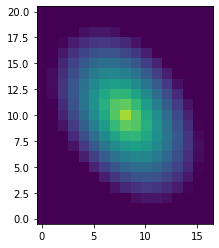

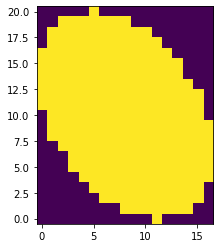

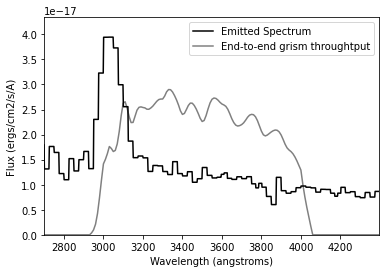

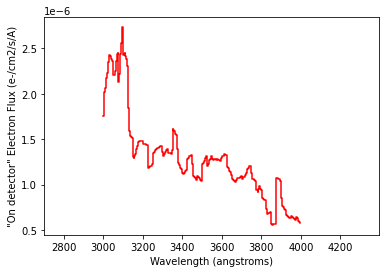

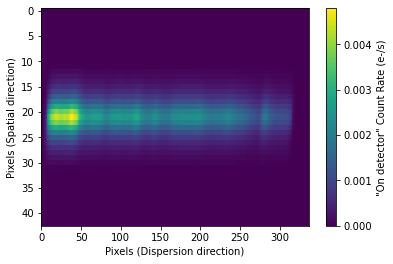

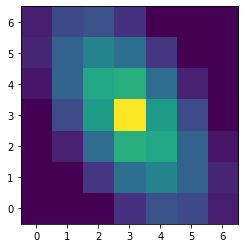

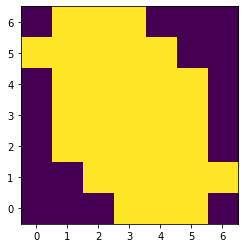

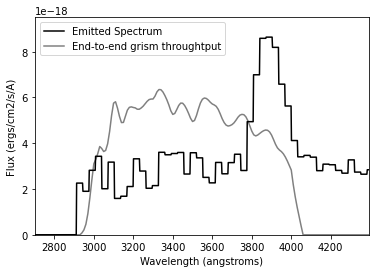

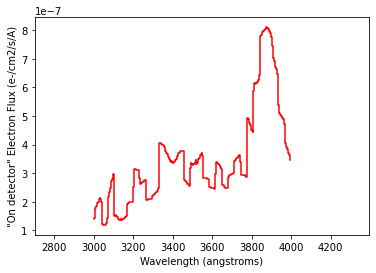

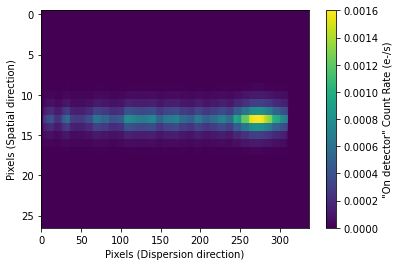

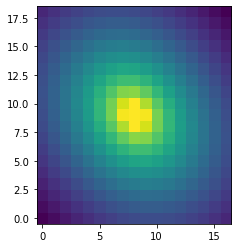

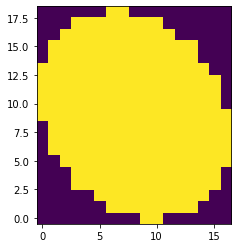

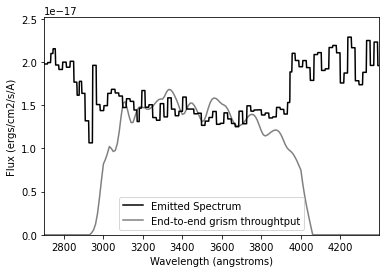

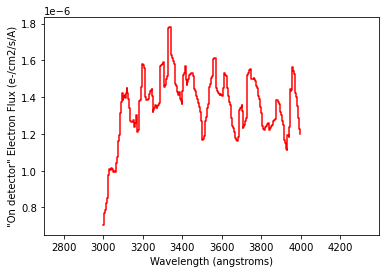

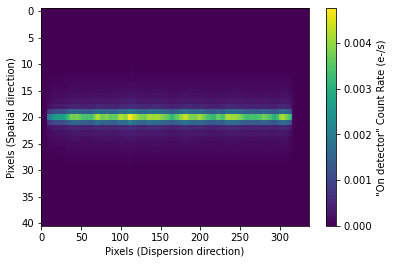

In [48]:
#Disperse/Observe with the "U" channel
grism_channel = "u" #disperse the spectrum with the u-band grism.

#disperse and observe scene
disperser.observe_scene(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                   spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=False, check=True)

#save
grism_scene_u = disperser.grism_scene


Text(0.5, 1.0, 'U grism scene')

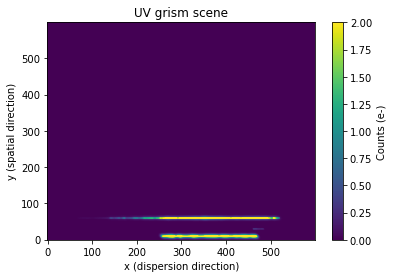

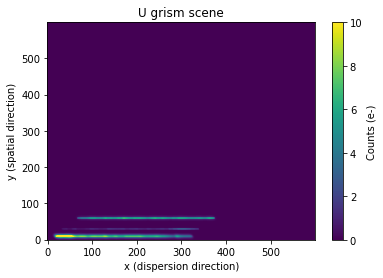

In [49]:
#Show grism scene
plt.figure()
plt.imshow(grism_scene_uv, origin="lower", aspect="auto", vmin=0, vmax=2)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("UV grism scene")

plt.figure()
plt.imshow(grism_scene_u, origin="lower", aspect="auto", vmin=0, vmax=10)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("U grism scene")


# Same but with "image_fov" set to True

In [50]:
#Disperse/Observe with the "UV" channel
grism_channel = "uv" #disperse the spectrum with the u-band grism.

#Exposure_time
exposure_time = 3600 #seconds

#disperse and observe scene
#If "image_fov" is True, then the gris_scene will have the same dimension as the input image scene.
#If not, the grism fov is increased to include the full extent of the dispersed spectra.
disperser.observe_scene(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                   spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=True, check=False)

#save
grism_scene_uv_imgfov = disperser.grism_scene


#Disperse/Observe with the "U" channel
grism_channel = "u" #disperse the spectrum with the u-band grism.

#disperse and observe scene
disperser.observe_scene(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                   spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=True, check=False)

#save
grism_scene_u_imgfov = disperser.grism_scene


Text(0.5, 1.0, 'U grism scene')

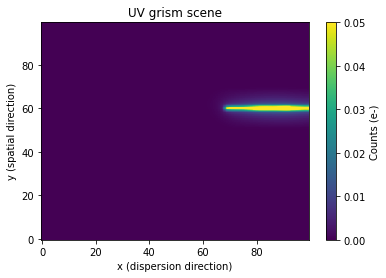

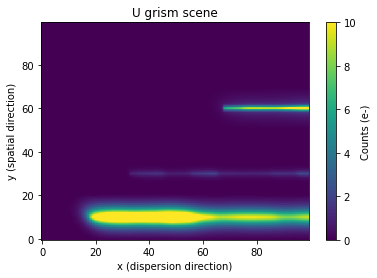

In [51]:
#Show grism scene
plt.figure()
plt.imshow(grism_scene_uv_imgfov, origin="lower", aspect="auto", vmin=0, vmax=0.05)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("UV grism scene")

plt.figure()
plt.imshow(grism_scene_u_imgfov, origin="lower", aspect="auto", vmin=0, vmax=10)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("U grism scene")



# Now with multi-dimensional direct images and seg maps to disperse objects that are overlapping in the direct imaging

## First: create the first scene (eg foreground) with non-overlapping sources

In [52]:
#Create sources in scene
#Use a sersic profiles

#CASTOR telescope pixel scale in arcsec
pix_scale = 0.1 

#fov in pixels
fov_size = 100

#sources
x_positions = [10, 30, 60]
y_positions = [10, 30, 60]
sources_eff_radius_arcsec = np.array([3/7.5, 1.5/7.5, 4/7.5]) #arcsec
sources_eff_radius_pixels = sources_eff_radius_arcsec/pix_scale
sersic_indexes = [1, 1.5, 3]
ellipticities = [0.35, 0.5, 0.2]
seg_thresholds = [1e-2, 1e-2, 1e-3]

#scene grid
x,y = np.meshgrid(np.arange(fov_size), np.arange(fov_size))

#sersic models
sersic_models = [Sersic2D(amplitude = 1, r_eff = r_eff, n=n, x_0=x_pos, y_0=y_pos,
                    ellip=ellip, theta=-1) 
                    for r_eff, n, x_pos, y_pos, ellip 
                    in zip(sources_eff_radius_pixels, sersic_indexes, x_positions, y_positions, ellipticities)]
#images and seg maps
sources_img = [sersic_model(x, y) for sersic_model in sersic_models]
sources_seg = [(src_img/np.max(src_img) > segtresh) * k for src_img, segtresh, k in zip(sources_img, seg_thresholds, range(1,4))]

#add on grid/scene
scene_direct_1 = np.nansum(sources_img, axis=0)
scene_seg_1 = np.nansum(sources_seg, axis=0)



## Second: create the second scene (eg background) with the sources that will overlap with the first scene (sources in the background scene must also be non-overlapping, multiple background scenes can be created if needed).

In [53]:
#Create overlapping sources in scene
#Use a sersic profiles

#CASTOR telescope pixel scale in arcsec
pix_scale = 0.1 

#fov in pixels
fov_size = 100

shift=5
#sources
x_positions = [60+shift, 10+shift, 30+shift]
y_positions = [60+shift, 10+shift, 30+shift]
sources_eff_radius_arcsec = np.array([3/7.5, 1.5/7.5, 4/7.5]) #arcsec
sources_eff_radius_pixels = sources_eff_radius_arcsec/pix_scale
sersic_indexes = [1, 1.5, 3]
ellipticities = [0.35, 0.5, 0.2]
seg_thresholds = [1e-2, 1e-2, 1e-3]

#scene grid
x,y = np.meshgrid(np.arange(fov_size), np.arange(fov_size))

#sersic models
sersic_models = [Sersic2D(amplitude = 1, r_eff = r_eff, n=n, x_0=x_pos, y_0=y_pos,
                    ellip=ellip, theta=-1) 
                    for r_eff, n, x_pos, y_pos, ellip 
                    in zip(sources_eff_radius_pixels, sersic_indexes, x_positions, y_positions, ellipticities)]
#images and seg maps
sources_img = [sersic_model(x, y) for sersic_model in sersic_models]
sources_seg = [(src_img/np.max(src_img) > segtresh) * k for src_img, segtresh, k in zip(sources_img, seg_thresholds, range(1,4))]

#add on grid/scene
scene_direct_2 = np.nansum(sources_img, axis=0)
scene_seg_2 = np.nansum(sources_seg, axis=0)



/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_50088/1684945262.py:10: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([-1, 0, 1], update_ticks=True)
/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_50088/1684945262.py:29: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([-1, 0, 1], update_ticks=True)
/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_50088/1684945262.py:48: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any 

Text(0.5, 1.0, 'Combined seg map')

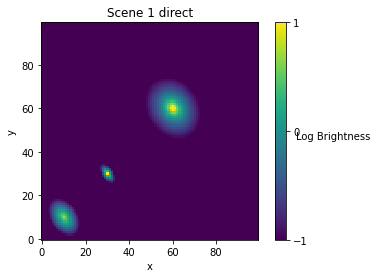

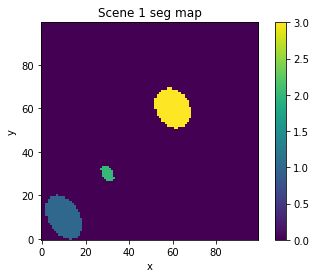

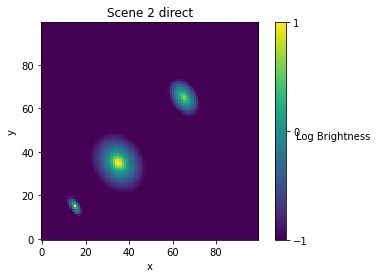

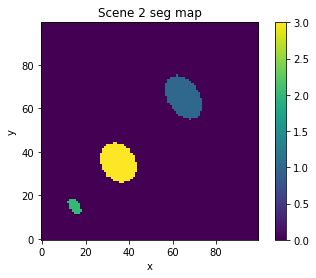

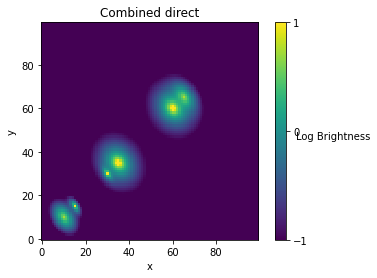

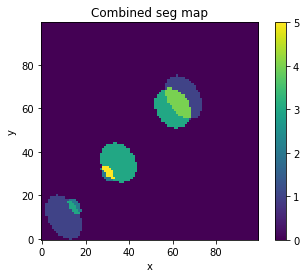

In [54]:
#Show scene 1 and scene 2

#scene 1 direct image scene
plt.figure()
plt.imshow(np.log10(scene_direct_1), origin='lower', interpolation='none', vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)
plt.title("Scene 1 direct")

#scene 1 segmentation map
plt.figure()
plt.imshow(scene_seg_1, origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Scene 1 seg map")


#scene 2 direct image scene
plt.figure()
plt.imshow(np.log10(scene_direct_2), origin='lower', interpolation='none', vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)
plt.title("Scene 2 direct")

#scene 2 segmentation map
plt.figure()
plt.imshow(scene_seg_2, origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Scene 2 seg map")


#combined direct image scene
plt.figure()
plt.imshow(np.log10(scene_direct_1+scene_direct_2), origin='lower', interpolation='none', vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)
plt.title("Combined direct")

#combined segmentation map
plt.figure()
plt.imshow(scene_seg_1+scene_seg_2, origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Combined seg map")



# Create multi dimension images, segmentations, associated spectra


In [55]:
#create multi dimension images, segmentations, associated spectra
scene_direct_multi = [scene_direct_1, scene_direct_2]
scene_seg_multi = [scene_seg_1, scene_seg_2]
spectra_multi = [spectra_norm, spectra_norm] #reuse same spectra as before



# Make the multi-dimensional scene

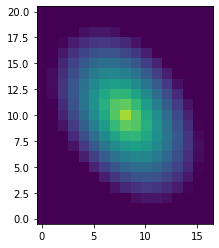

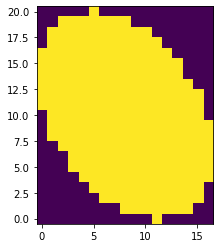

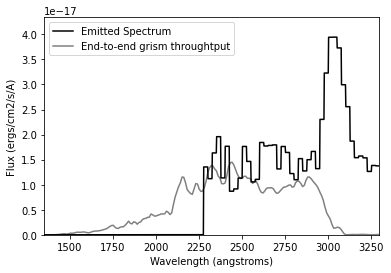

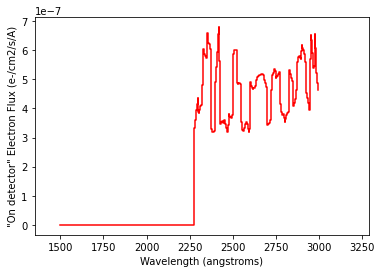

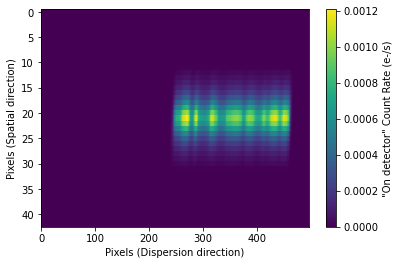

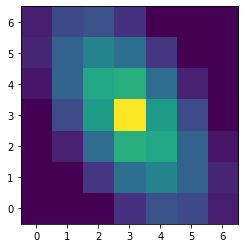

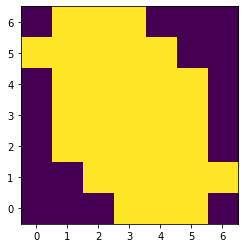

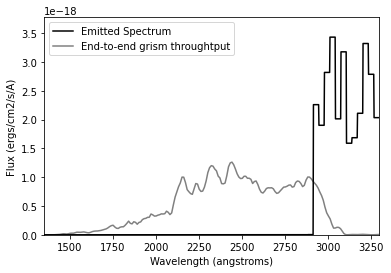

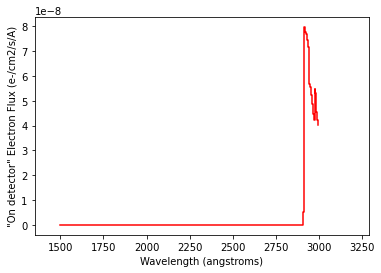

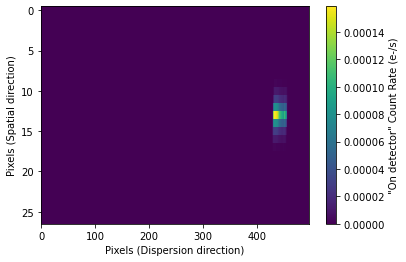

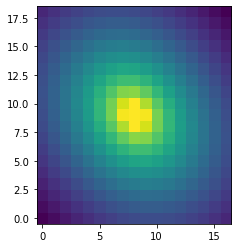

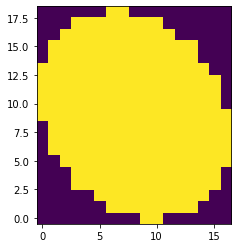

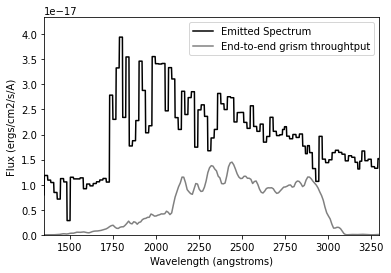

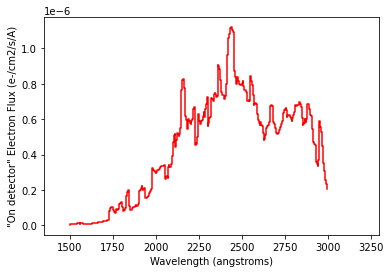

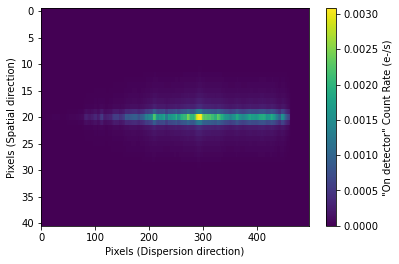

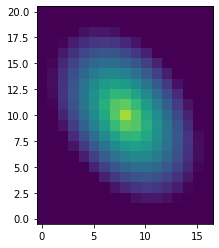

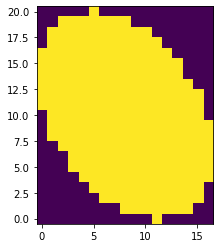

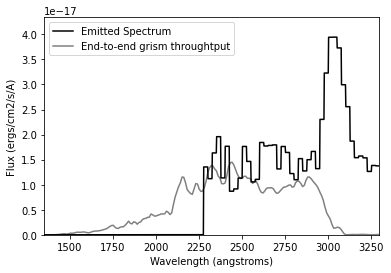

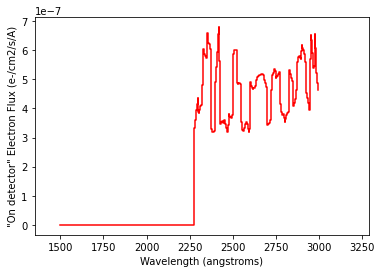

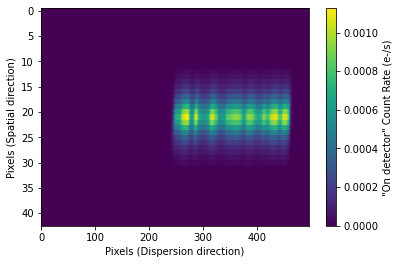

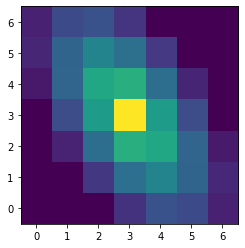

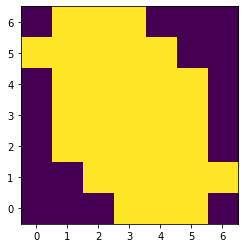

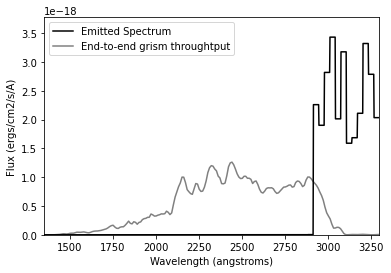

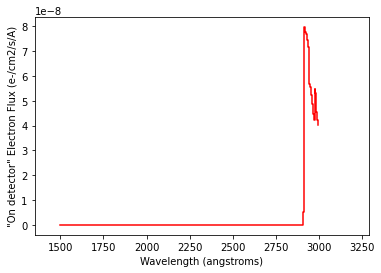

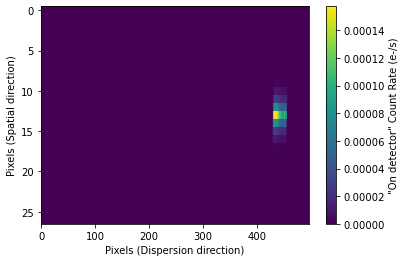

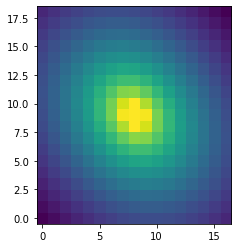

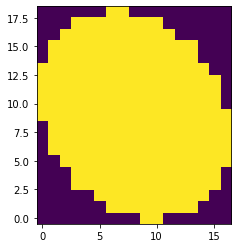

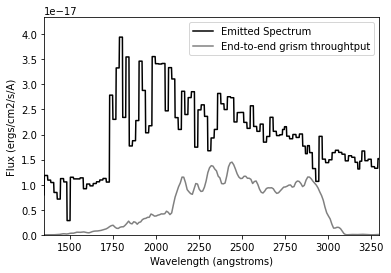

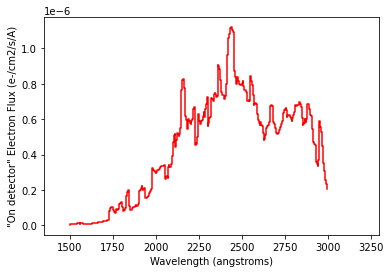

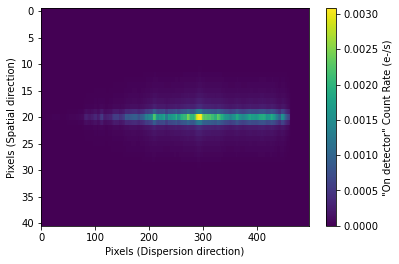

In [56]:
#scene properties
spectra = spectra_multi
scene_direct = scene_direct_multi
scene_seg = scene_seg_multi

#Disperse/Observe with the "UV" channel
grism_channel = "uv" #disperse the spectrum with the u-band grism.

#Exposure_time
exposure_time = 3600 #seconds

#disperse and observe scene
disperser.observe_scene_multi_dim(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                        spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=False, check=True)

#save
grism_scene_uv = disperser.grism_scene_multi_dim



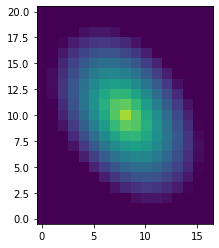

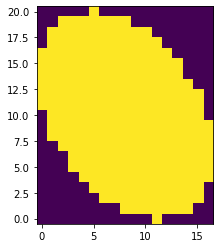

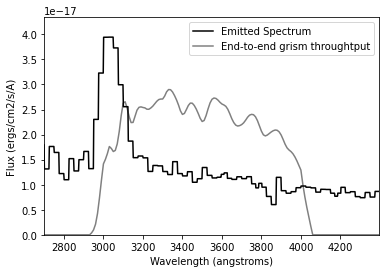

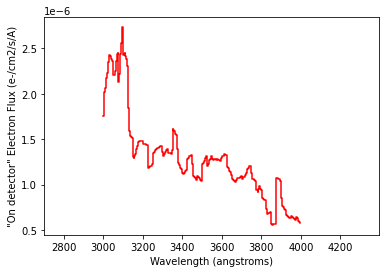

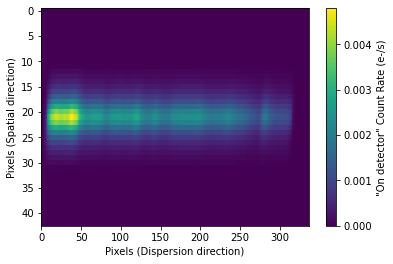

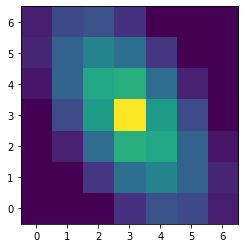

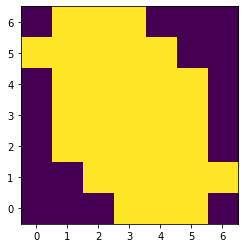

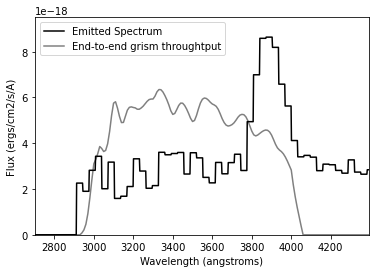

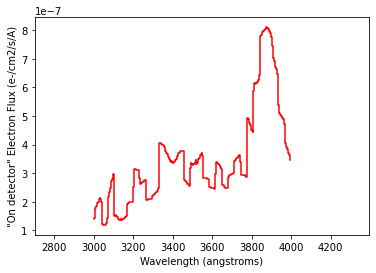

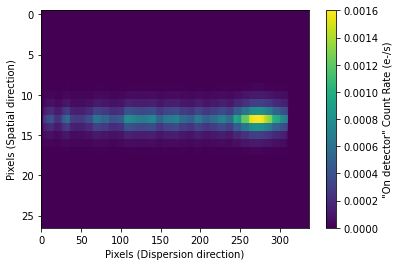

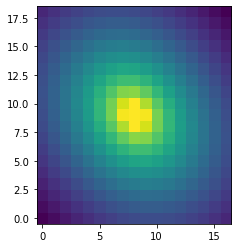

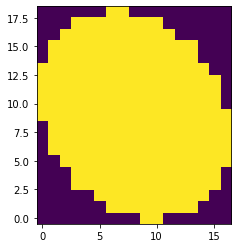

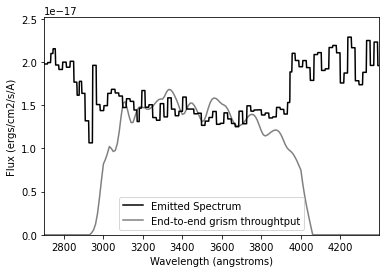

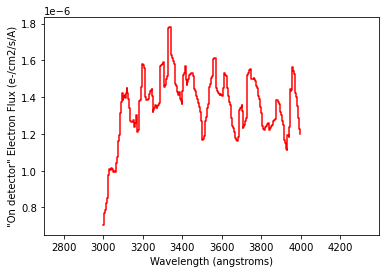

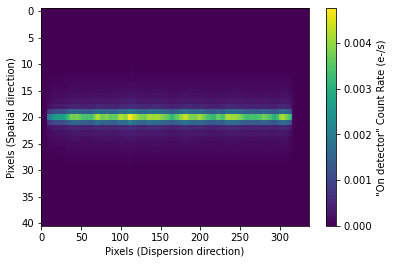

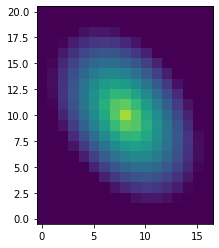

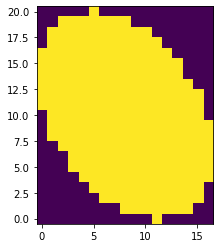

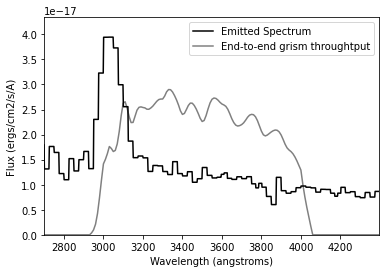

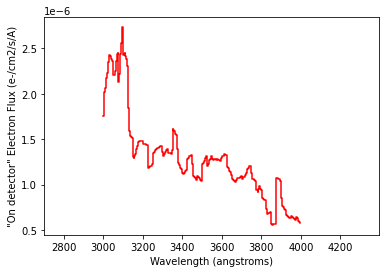

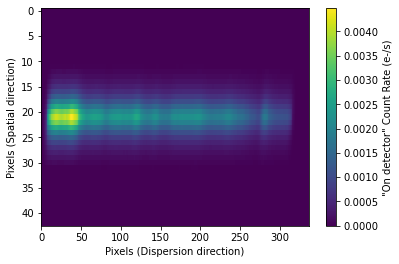

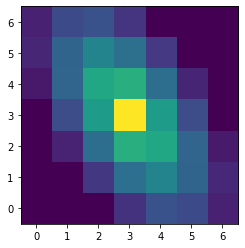

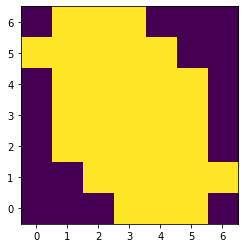

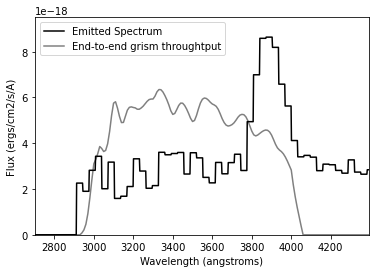

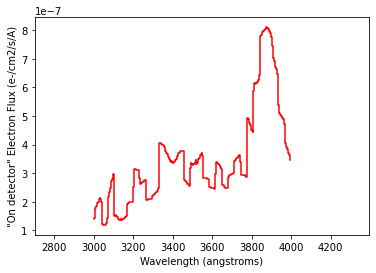

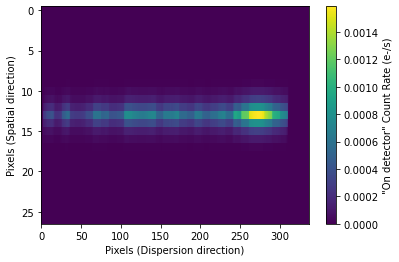

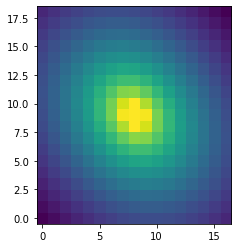

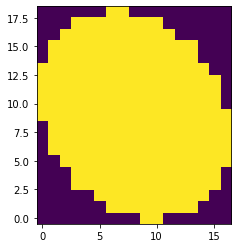

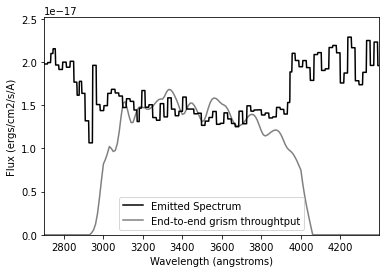

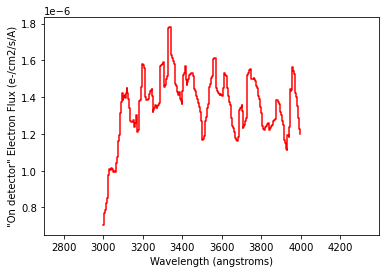

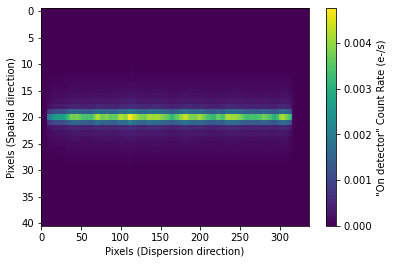

In [57]:
#Disperse/Observe with the "U" channel
grism_channel = "u" #disperse the spectrum with the u-band grism.

#disperse and observe scene
disperser.observe_scene_multi_dim(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                        spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=False, check=True)


#save
grism_scene_u = disperser.grism_scene_multi_dim


Text(0.5, 1.0, 'U grism scene')

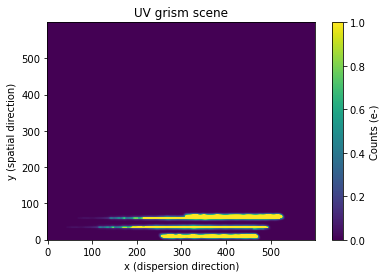

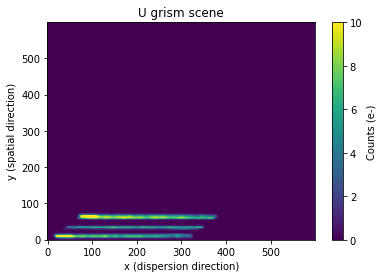

In [58]:
#Show grism scene
plt.figure()
plt.imshow(grism_scene_uv, origin="lower", aspect="auto", vmin=0, vmax=1)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("UV grism scene")

plt.figure()
plt.imshow(grism_scene_u, origin="lower", aspect="auto", vmin=0, vmax=10)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("U grism scene")



# Same but with "image_fov" set to True

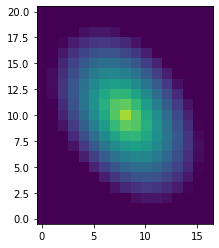

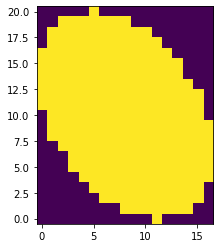

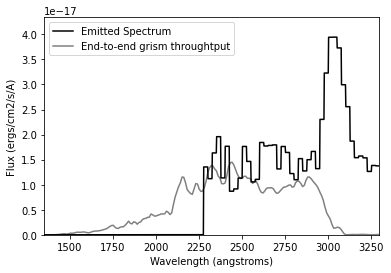

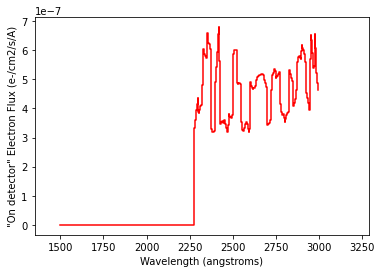

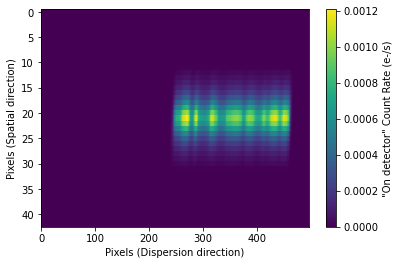

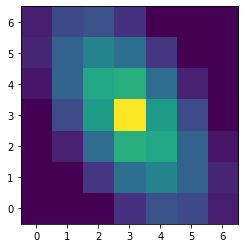

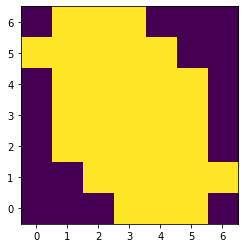

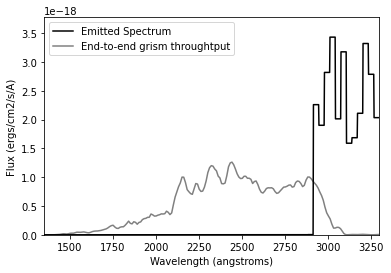

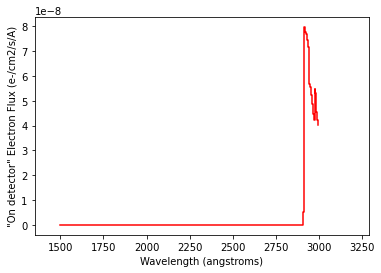

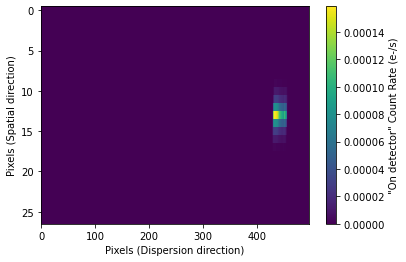

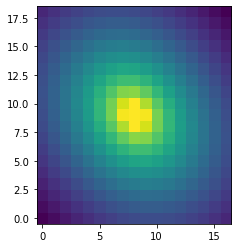

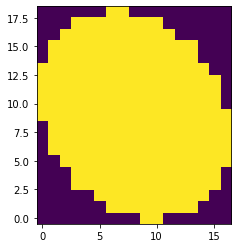

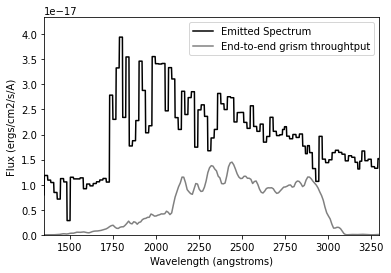

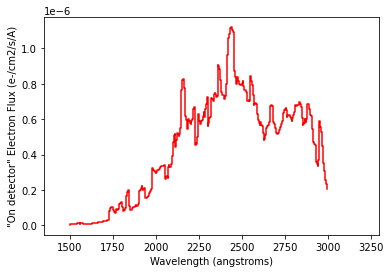

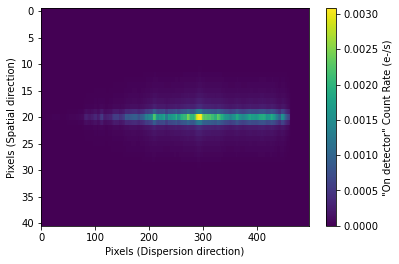

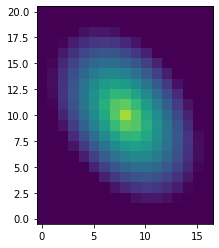

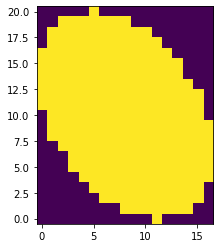

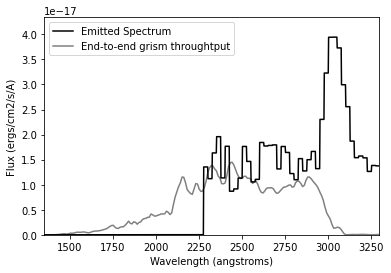

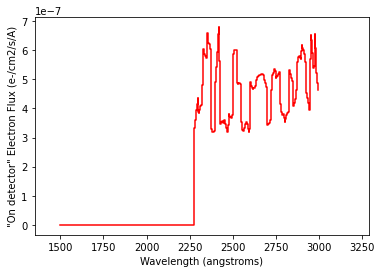

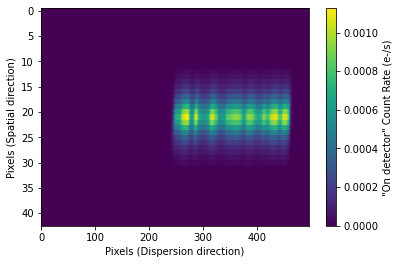

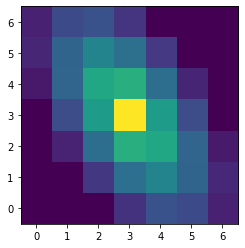

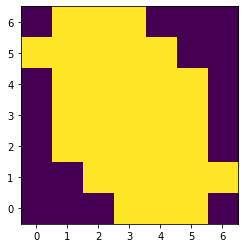

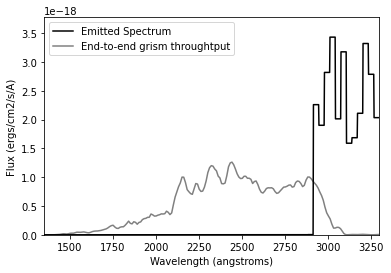

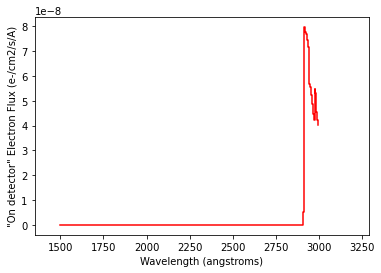

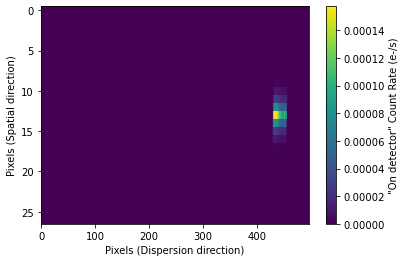

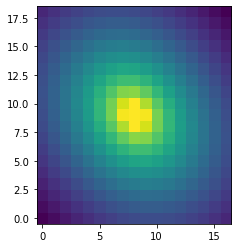

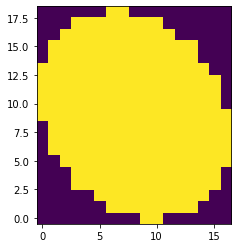

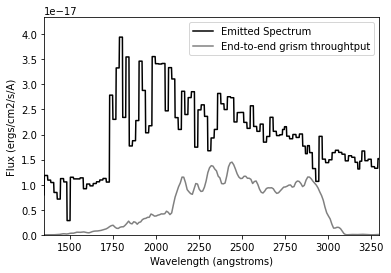

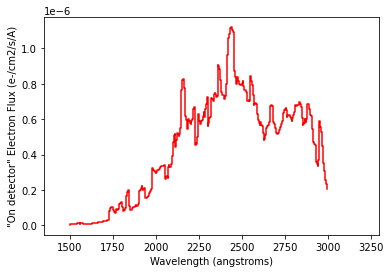

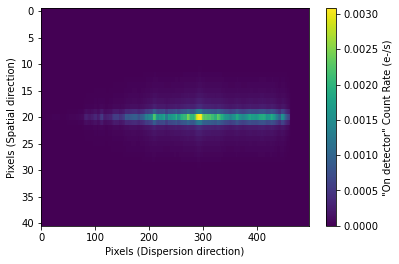

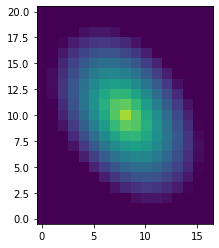

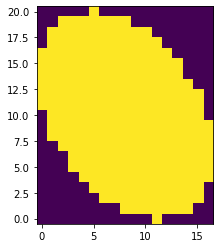

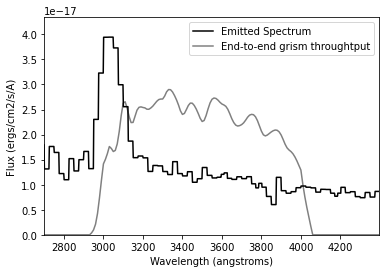

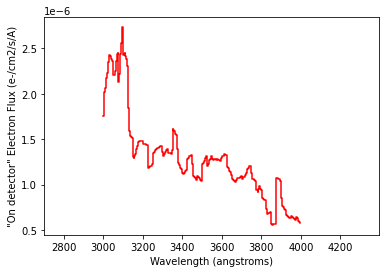

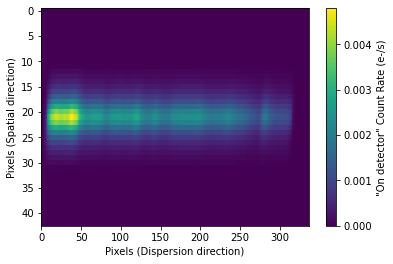

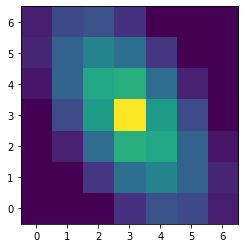

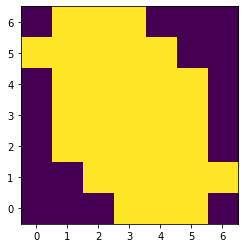

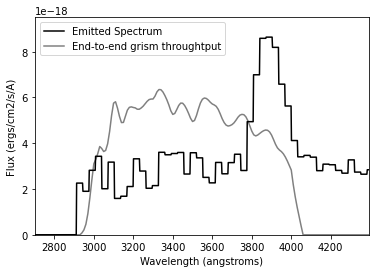

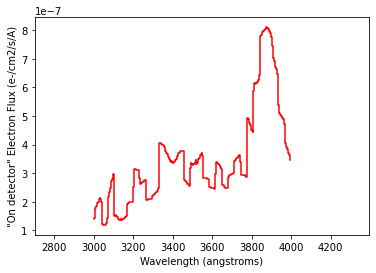

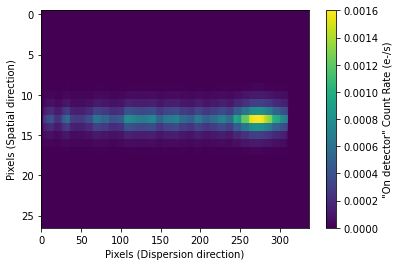

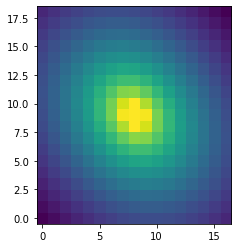

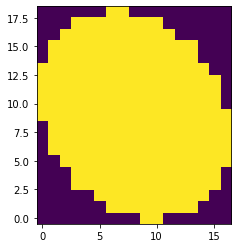

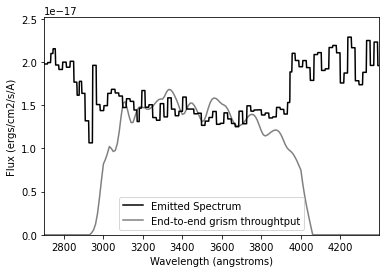

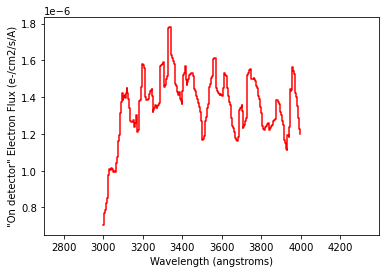

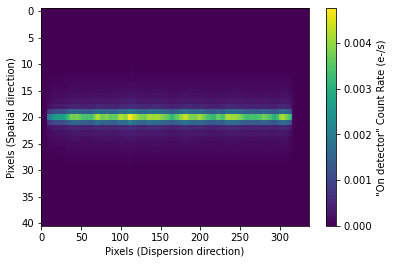

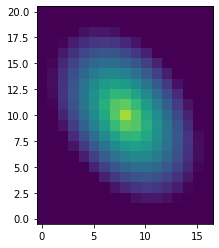

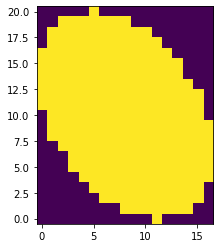

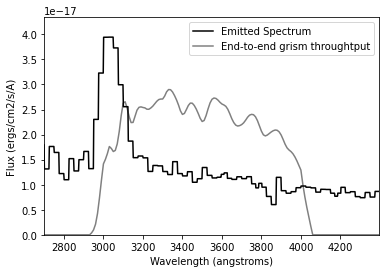

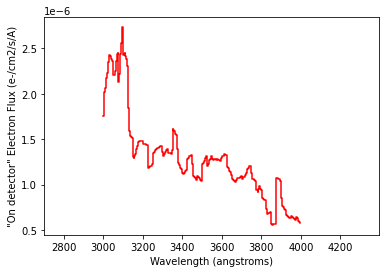

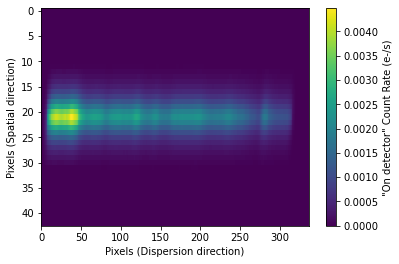

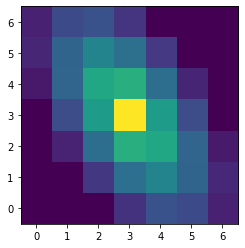

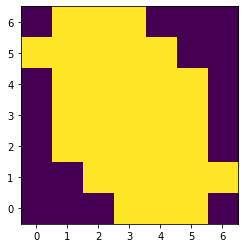

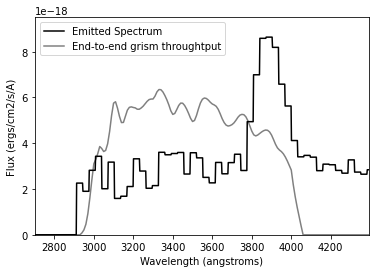

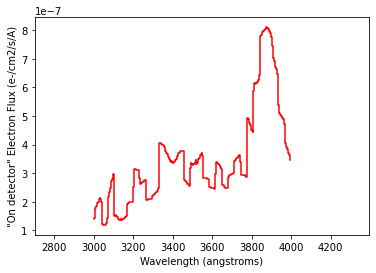

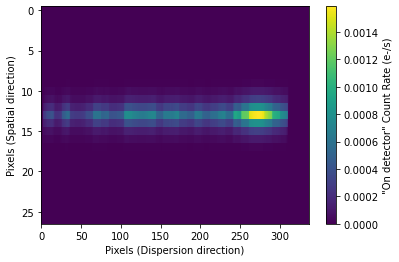

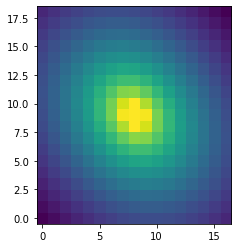

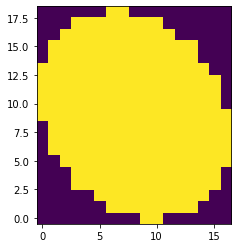

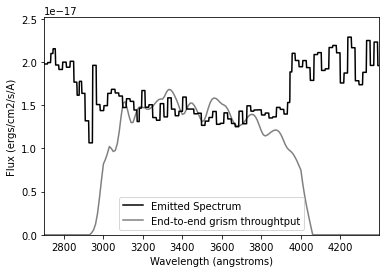

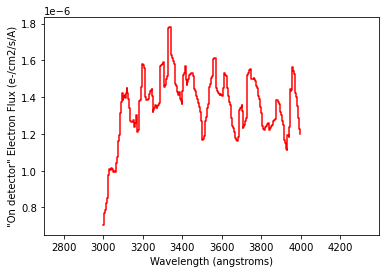

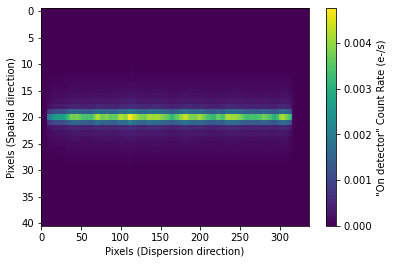

In [59]:
#scene properties
spectra = spectra_multi
scene_direct = scene_direct_multi
scene_seg = scene_seg_multi

#Disperse/Observe with the "UV" channel
grism_channel = "uv" #disperse the spectrum with the u-band grism.

#Exposure_time
exposure_time = 3600 #seconds

#disperse and observe scene
disperser.observe_scene_multi_dim(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                        spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=True, check=True)

#save
grism_scene_uv_imagefov = disperser.grism_scene_multi_dim


#Disperse/Observe with the "U" channel
grism_channel = "u" #disperse the spectrum with the u-band grism.

#disperse and observe scene
disperser.observe_scene_multi_dim(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                        spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, image_fov=True, check=True)


#save
grism_scene_u_imagefov = disperser.grism_scene_multi_dim




Text(0.5, 1.0, 'U grism scene')

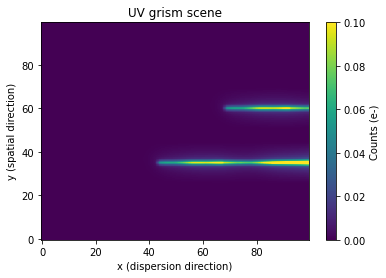

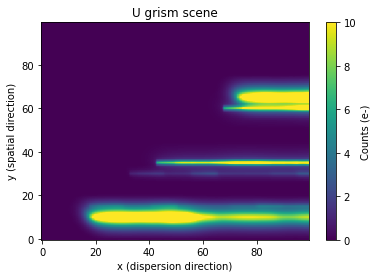

In [60]:
#Show grism scene
plt.figure()
plt.imshow(grism_scene_uv_imagefov, origin="lower", aspect="auto", vmin=0, vmax=0.1)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("UV grism scene")

plt.figure()
plt.imshow(grism_scene_u_imagefov, origin="lower", aspect="auto", vmin=0, vmax=10)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("U grism scene")
